In [59]:
!pip install --upgrade pandas-datareader==0.10.0

In [101]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas_datareader as data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [102]:
start = '2015-05-27'
end = '2020-05-22'
#start = '2015-06-08'
#end = '2020-06-05'
# Reliance_Stock
df = data.DataReader('AAPL', 'yahoo', start ,end)
df = df.dropna()
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-05-27,33.064999,32.512501,32.584999,33.009998,183332800.0,30.091169
2015-05-28,32.987499,32.775002,32.965000,32.945000,122933200.0,30.031916
2015-05-29,32.862499,32.474998,32.807499,32.570000,203538000.0,29.690077
2015-06-01,32.847500,32.512501,32.570000,32.634998,128451200.0,29.749321
2015-06-02,32.665001,32.330002,32.465000,32.490002,134670400.0,29.617153


In [62]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-18,79.125000,77.580002,78.292503,78.739998,135178400.0,77.882950
2020-05-19,79.629997,78.252502,78.757500,78.285004,101729600.0,77.432899
2020-05-20,79.879997,79.129997,79.169998,79.807503,111504800.0,78.938828
2020-05-21,80.222504,78.967499,79.665001,79.212502,102688800.0,78.350304
2020-05-22,79.807503,78.837502,78.942497,79.722504,81803200.0,78.854759


In [63]:
df_close = df['Close']

In [64]:
df_close.shape

(1258,)

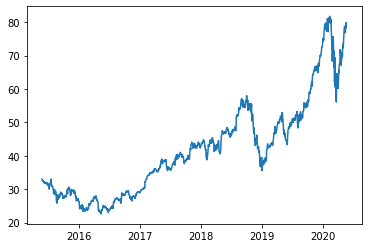

In [65]:
plt.plot(df_close)

In [66]:
df_close

Date
2015-05-27    33.009998
2015-05-28    32.945000
2015-05-29    32.570000
2015-06-01    32.634998
2015-06-02    32.490002
                ...    
2020-05-18    78.739998
2020-05-19    78.285004
2020-05-20    79.807503
2020-05-21    79.212502
2020-05-22    79.722504
Name: Close, Length: 1258, dtype: float64

Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1

In [67]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [68]:
df_close.shape

(1258, 1)

In [69]:
df_close

array([[0.17605334],
       [0.17495567],
       [0.16862281],
       ...,
       [0.96635143],
       [0.95630328],
       [0.964916  ]])

In [70]:
#Split the data into train and test split
# 75% is for training data and 25% data is for testing
training_size = int(len(df_close) * 0.60)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [71]:
len(train_data), len(test_data)

(754, 504)

In [72]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [73]:
# divide our data into x_train and y_train
# let take see at logic here 
# we have some closing stock price 34 36 33 40 39 38 37 42 44 38 ( these are 10 days data )
# Now we have to predict the 11th day data
# so the price on the particular day will be dependent on last few days 
# so 10 days are the x_train 
# so 11th day will become my y_train which to be predict
# reshape into x = t, t+1 , t+2 , t+3 and Y = t+ 4
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [74]:
x_train.shape , y_train.shape


((653, 100), (653,))

In [75]:
x_test.shape , y_test.shape

((403, 100), (403,))

In [76]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_train.shape

(653, 100, 1)

In [77]:
#Create the LSTM Model
# stack LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
11/11 [==============================] - 23s 1s/step - loss: 0.0182 - val_loss: 0.0264
Epoch 2/100
11/11 [==============================] - 10s 844ms/step - loss: 0.0041 - val_loss: 0.0184
Epoch 3/100
11/11 [==============================] - 9s 841ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 4/100
11/11 [==============================] - 9s 809ms/step - loss: 9.1477e-04 - val_loss: 0.0051
Epoch 5/100
11/11 [==============================] - 6s 496ms/step - loss: 7.2242e-04 - val_loss: 0.0054
Epoch 6/100
11/11 [==============================] - 4s 393ms/step - loss: 6.0775e-04 - val_loss: 0.0040
Epoch 7/100
11/11 [==============================] - 4s 391ms/step - loss: 5.9045e-04 - val_loss: 0.0040
Epoch 8/100
11/11 [==============================] - 4s 398ms/step - loss: 5.4380e-04 - val_loss: 0.0042
Epoch 9/100
11/11 [==============================] - 4s 391ms/step - loss: 5.4301e-04 - val_loss: 0.0039
Epoch 10/100
11/11 [==============================] - 4s 390ms/step 

In [80]:
model.save('keras_model.h5')

In [81]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [82]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [83]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

33.74196647914983

In [84]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

55.35785035990333

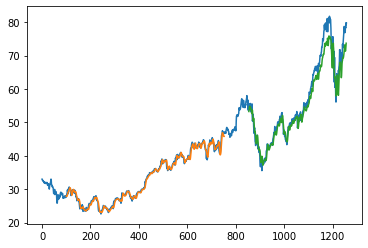

In [85]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
# test data set output is in green color
# training data set output is in orange color 
# blue color is of actual data set

### Predict the next 30 days Stock Price

In [86]:
len(test_data) 
time_stamp = 100

In [87]:
x_input = test_data[(len(test_data)-time_stamp):].reshape(1,-1)
print(x_input.shape)
print(len(test_data))
print(len(test_data) - time_stamp)

(1, 100)
504
404


In [88]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [89]:
len(temp_input)

100

In [90]:
lst_output=[]
# i have changes n_steps from 100 to x_input.shape
n_steps= time_stamp
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.8776263]
101
1 day input [0.88664188 0.87431387 0.88431976 0.87836699 0.89863207 0.92582113
 0.92877639 0.95676763 0.93869789 0.93304055 0.94950595 0.96424048
 0.95512115 0.95989192 0.96635143 0.96246722 0.92295027 0.95984966
 0.98792529 0.98594099 0.92531453 0.92172588 0.96474708 0.97572406
 0.99159833 0.9697289  0.97614615 0.96795564 1.         0.99016289
 0.99050072 0.96538034 0.98488552 0.97086877 0.94025997 0.87748029
 0.83483905 0.85413318 0.77336815 0.77269263 0.88014011 0.8400743
 0.89673216 0.85527317 0.83884991 0.74233727 0.82327108 0.781432
 0.66659625 0.79215567 0.64118044 0.68614369 0.6600101  0.6520307
 0.58642236 0.56586165 0.66089672 0.65515493 0.70970191 0.66452756
 0.69437638 0.69218098 0.63569196 0.65266396 0.63780291 0.72671618
 0.71388155 0.74191505 0.75002103 0.77222828 0.83049049 0.81942913
 0.82897067 0.81254741 0.78776486 0.75162538 0.78426073 0.77974327
 0.81326519 0.81410962 0.79473097 0.83336149 0.85898834 0.83901882
 0.85628639 0.87486273 0.88782401 0.90

In [91]:
day_new = np.arange(1,time_stamp+1)
#30 days we will predict
day_pred = np.arange(time_stamp+1,(time_stamp+31))

In [92]:
len(df_close)

1258

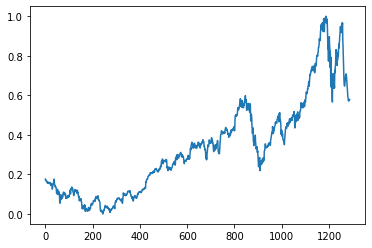

In [93]:
df3 = df_close.tolist()
df3.extend(lst_output)
plt.plot(df3)

In [94]:
lst_output

[[0.8776262998580933],
 [0.8478090167045593],
 [0.800294816493988],
 [0.7513133883476257],
 [0.7086718678474426],
 [0.6755982637405396],
 [0.6550136804580688],
 [0.6467084884643555],
 [0.6487644910812378],
 [0.6583073139190674],
 [0.6720148921012878],
 [0.6867222785949707],
 [0.6992055177688599],
 [0.7069269418716431],
 [0.7082343101501465],
 [0.7025774121284485],
 [0.6905181407928467],
 [0.6735333800315857],
 [0.6536828875541687],
 [0.6332210302352905],
 [0.614220380783081],
 [0.5978625416755676],
 [0.5850589275360107],
 [0.576621949672699],
 [0.5722505450248718],
 [0.5710537433624268],
 [0.5721030831336975],
 [0.5744049549102783],
 [0.576968789100647],
 [0.5789003372192383]]

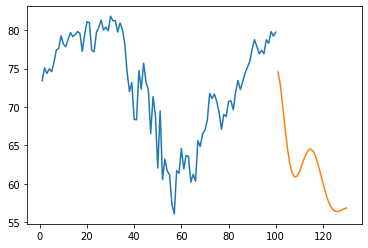

In [95]:
# this will plot read data
plt.plot(day_new, scaler.inverse_transform(df_close[(len(df_close)-time_stamp):]))
# this will plot predict data
plt.plot(day_pred, scaler.inverse_transform(lst_output))